In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

**Introduction** \|\| [Tensors](tensors_deeper_tutorial.html) \|\|
[Autograd](autogradyt_tutorial.html) \|\| [Building
Models](modelsyt_tutorial.html) \|\| [TensorBoard
Support](tensorboardyt_tutorial.html) \|\| [Training
Models](trainingyt.html) \|\| [Model Understanding](captumyt.html)

Introduction to PyTorch
=======================

Follow along with the video below or on
[youtube](https://www.youtube.com/watch?v=IC0_FRiX-sw).



In [1]:
import torch

Let's see a few basic tensor manipulations. First, just a few of the
ways to create tensors:


In [4]:
z = torch.zeros(5, 3)
print(z)
print(z.dtype)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
torch.float32


Above, we create a 5x3 matrix filled with zeros, and query its datatype
to find out that the zeros are 32-bit floating point numbers, which is
the default PyTorch.

What if you wanted integers instead? You can always override the
default:


In [5]:
i = torch.ones((5, 3), dtype=torch.int16)
print(i)

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]], dtype=torch.int16)


You can see that when we do change the default, the tensor helpfully
reports this when printed.

It's common to initialize learning weights randomly, often with a
specific seed for the PRNG for reproducibility of results:


In [6]:
torch.manual_seed(1729)
r1 = torch.rand(2, 2)
print('A random tensor:')
print(r1)

r2 = torch.rand(2, 2)
print('\nA different random tensor:')
print(r2) # new values

torch.manual_seed(1729)
r3 = torch.rand(2, 2)
print('\nShould match r1:')
print(r3) # repeats values of r1 because of re-seed

A random tensor:
tensor([[0.3126, 0.3791],
        [0.3087, 0.0736]])

A different random tensor:
tensor([[0.4216, 0.0691],
        [0.2332, 0.4047]])

Should match r1:
tensor([[0.3126, 0.3791],
        [0.3087, 0.0736]])


PyTorch tensors perform arithmetic operations intuitively. Tensors of
similar shapes may be added, multiplied, etc. Operations with scalars
are distributed over the tensor:


In [ ]:
ones = torch.ones(2, 3)
print(ones)

twos = torch.ones(2, 3) * 2 # every element is multiplied by 2
print(twos)

threes = ones + twos       # addition allowed because shapes are similar
print(threes)              # tensors are added element-wise
print(threes.shape)        # this has the same dimensions as input tensors

r1 = torch.rand(2, 3)
r2 = torch.rand(3, 2)
# uncomment this line to get a runtime error
# r3 = r1 + r2

There's a good deal more to know about the power of PyTorch tensors,
including how to set them up for parallel computations on GPU - we'll be
going into more depth in another video.

PyTorch Models
==============

Follow along with the video beginning at
[10:00](https://www.youtube.com/watch?v=IC0_FRiX-sw&t=600s).

Let's talk about how we can express models in PyTorch


In [2]:
import torch                     # for all things PyTorch
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F  # for the activation function

![](https://pytorch.org/tutorials/_static/img/mnist.png)

*Figure: LeNet-5*

Above is a diagram of LeNet-5, one of the earliest convolutional neural
nets, and one of the drivers of the explosion in Deep Learning. It was
built to read small images of handwritten numbers (the MNIST dataset),
and correctly classify which digit was represented in the image.

Here's the abridged version of how it works:

-   Layer C1 is a convolutional layer, meaning that it scans the input
    image for features it learned during training. It outputs a map of
    where it saw each of its learned features in the image. This
    "activation map" is downsampled in layer S2.
-   Layer C3 is another convolutional layer, this time scanning C1's
    activation map for *combinations* of features. It also puts out an
    activation map describing the spatial locations of these feature
    combinations, which is downsampled in layer S4.
-   Finally, the fully-connected layers at the end, F5, F6, and OUTPUT,
    are a *classifier* that takes the final activation map, and
    classifies it into one of ten bins representing the 10 digits.

How do we express this simple neural network in code?


In [8]:
class LeNet(nn.Module):

    def __init__(self):
        # the call to super().__init__() within a class that inherits from another class is crucial for properly initializing the parent class
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # .view is to reshape the tensor
        # each row represents an example. Each column is the feature vector
        # -1 means as many rows as necessary
        x = x.view(-1, self.num_flat_features(x)) #reshape the tensor into 2D before passing into the fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1 #multiply channel * height * width
        for s in size:
            num_features *= s
        return num_features

Looking over this code, you should be able to spot some structural
similarities with the diagram above.

This demonstrates the structure of a typical PyTorch model:

-   <mark> It inherits from `torch.nn.Module`</mark>  - modules may be nested - in
    fact, even the `Conv2d` and `Linear` layer classes inherit from
    `torch.nn.Module`.
-   <mark> A model will have an `__init__()` function </mark>, where it instantiates
    its layers, and loads any data artifacts it might need (e.g., an NLP
    model might load a vocabulary).
-   <mark> A model will have a `forward()` function </mark>. This is where the actual
    computation happens: An input is passed through the network layers
    and various functions to generate an output.
-   Other than that, you can build out your model class like any other
    Python class, adding whatever properties and methods you need to
    support your model's computation.

Let's instantiate this object and run a sample input through it.


In [9]:
net = LeNet()
print(net)                         # what does the object tell us about itself?

input = torch.rand(1, 1, 32, 32)   # stand-in for a 32x32 black & white image
print('\nImage batch shape:')
print(input.shape)

output = net(input)                # we don't call forward() directly
print('\nRaw output:')
print(output)
print(output.shape)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Image batch shape:
torch.Size([1, 1, 32, 32])

Raw output:
tensor([[ 0.0971, -0.0252,  0.0900, -0.0478, -0.0406, -0.0383, -0.0923,  0.0133,
          0.0628, -0.0285]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


There are a few important things happening above:

First, we instantiate the `LeNet` class, and we print the `net` object.
A subclass of `torch.nn.Module` will report the layers it has created
and their shapes and parameters. This can provide a handy overview of a
model if you want to get the gist of its processing.

Below that, we create a dummy input representing a 32x32 image with 1
color channel. Normally, you would load an image tile and convert it to
a tensor of this shape.

You may have noticed an extra dimension to our tensor - the *batch
dimension.* PyTorch models assume they are working on *batches* of data
- for example, a batch of 16 of our image tiles would have the shape
`(16, 1, 32, 32)`. Since we're only using one image, we create a batch
of 1 with shape `(1, 1, 32, 32)`.

We ask the model for an inference by calling it like a function:
`net(input)`. The output of this call represents the model's confidence
that the input represents a particular digit. (Since this instance of
the model hasn't learned anything yet, we shouldn't expect to see any
signal in the output.) Looking at the shape of `output`, we can see that
it also has a batch dimension, the size of which should always match the
input batch dimension. If we had passed in an input batch of 16
instances, `output` would have a shape of `(16, 10)`.

Datasets and Dataloaders
========================

Follow along with the video beginning at
[14:00](https://www.youtube.com/watch?v=IC0_FRiX-sw&t=840s).

Below, we're going to demonstrate using one of the ready-to-download,
open-access datasets from TorchVision, how to transform the images for
consumption by your model, and how to use the DataLoader to feed batches
of data to your model.

<mark> The first thing we need to do is transform our incoming images into a
PyTorch tensor. </mark>


In [3]:
#%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

In [14]:
from torch.utils.data import ConcatDataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#stack all train images together into a tensor of shape #(50000, 3, 32, 32)
x = torch.stack([sample[0] for sample in ConcatDataset([trainset])])
print(x.size())
#get the mean of each channel
mean = torch.mean(x, dim=(0,2,3)) #tensor([0.4914, 0.4822, 0.4465])
print(mean)
std = torch.std(x, dim=(0,2,3)) #tensor([0.2470, 0.2435, 0.2616])
print(std)

Files already downloaded and verified
torch.Size([50000, 3, 32, 32])
tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


Here, we specify two transformations for our input:

-   `transforms.ToTensor()` converts images loaded by Pillow into
    PyTorch tensors.
-   `transforms.Normalize()` adjusts the values of the tensor so that
    their average is zero and their standard deviation is 1.0. Most
    activation functions have their strongest gradients around x = 0, so
    centering our data there can speed learning. The values passed to
    the transform are the means (first tuple) and the standard
    deviations (second tuple) of the rgb values of the images in the
    dataset.
There are many more transforms available, including cropping, centering,
rotation, and reflection.

Next, we'll create an instance of the CIFAR10 dataset. This is a set of
32x32 color image tiles representing 10 classes of objects: 6 of animals
(bird, cat, deer, dog, frog, horse) and 4 of vehicles (airplane,
automobile, ship, truck):


In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 63239371.47it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>When you run the cell above, it may take a little time for thedataset to download.</p>
</div>

This is an example of creating a dataset object in PyTorch. Downloadable
datasets (like CIFAR-10 above) are subclasses of
`torch.utils.data.Dataset`. `Dataset` classes in PyTorch include the
downloadable datasets in TorchVision, Torchtext, and TorchAudio, as well
as utility dataset classes such as `torchvision.datasets.ImageFolder`,
which will read a folder of labeled images. You can also create your own
subclasses of `Dataset`.

When we instantiate our dataset, we need to tell it a few things:

-   The filesystem path to where we want the data to go.
-   Whether or not we are using this set for training; most datasets
    will be split into training and test subsets.
-   Whether we would like to download the dataset if we haven't already.
-   The transformations we want to apply to the data.

Once your dataset is ready, you can give it to the `DataLoader`:


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

A `Dataset` subclass wraps access to the data, and is specialized to the
type of data it's serving. <mark>The `DataLoader` knows *nothing* about the
data, but organizes the input tensors served by the `Dataset` into
batches with the parameters you specify.</mark>

In the example above, we've asked a `DataLoader` to give us batches of 4
images from `trainset`, randomizing their order (`shuffle=True`), and we
told it to spin up two workers to load data from disk.

It's good practice to visualize the batches your `DataLoader` serves:


truck  ship   car  frog


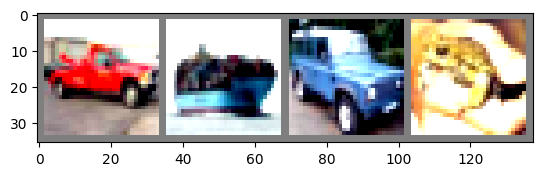

In [6]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Running the above cell should show you a strip of four images, and the
correct label for each.

Training Your PyTorch Model
===========================

Follow along with the video beginning at
[17:10](https://www.youtube.com/watch?v=IC0_FRiX-sw&t=1030s).

Let's put all the pieces together, and train a model:


In [7]:
#%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

First, we'll need training and test datasets. If you haven't already,
run the cell below to make sure the dataset is downloaded. (It may take
a minute.)


In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


We'll run our check on the output from `DataLoader`:


 ship   dog horse plane
torch.Size([4, 3, 32, 32])


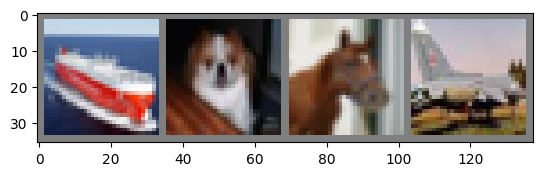

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader) #iter() generates an iterator.
#An iterator in Python does not directly expose the elements it contains;
#instead, it provides a way to sequentially access elements one at a time.
#This is where the .next() method becomes essential.
images, labels = next(dataiter) #iterate over the trainloader to get a single batch

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

print(images.shape) #batchsize=4 (processing 4 images at a time), 3 channels, 32x32
#each image can be called such as images[0]

This is the model we'll train. If it looks familiar, that's because it's
a variant of LeNet - discussed earlier in this video - adapted for
3-color images.


In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, kernel size 5x5
        self.pool = nn.MaxPool2d(2, 2) # 2x2 max pooling with stride 2
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, kernel size 5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # input vector size is 16x5x5, output 120 units
        self.fc2 = nn.Linear(120, 84) # input 120 units, output 84 units
        self.fc3 = nn.Linear(84, 10) #inptu 84 units, output 10 units

    def forward(self, x): #input shape (32x32x3)
        x = self.pool(F.relu(self.conv1(x))) # conv1(x) -> 28x28x6; pool -> 14x14x6
        x = self.pool(F.relu(self.conv2(x))) # conv2(x) -> 10x10x16; pool -> 5x5x16
        x = x.view(-1, 16 * 5 * 5) # -1 means keep the number of batches, each image is flattened into a vector of shape 400
        x = F.relu(self.fc1(x)) # [batch size, 120]
        x = F.relu(self.fc2(x)) # [batch size, 84]
        x = self.fc3(x) # [batch size, 10]
        return x


net = Net()

The last ingredients we need are a loss function and an optimizer:


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

The loss function, as discussed earlier in this video, is a measure of
how far from our ideal output the model's prediction was. Cross-entropy
loss is a typical loss function for classification models like ours.

The **optimizer** is what drives the learning. Here we have created an
optimizer that implements *stochastic gradient descent,* one of the more
straightforward optimization algorithms. Besides parameters of the
algorithm, like the learning rate (`lr`) and momentum, we also pass in
`net.parameters()`, which is a collection of all the learning weights in
the model - which is what the optimizer adjusts.

Finally, all of this is assembled into the training loop. Go ahead and
run this cell, as it will likely take a few minutes to execute:


In [14]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): #iterate over trainloader, start from 0
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad() #gradients need to be reset across each batch and epoch

        # forward + backward + optimize
        outputs = net(inputs) # model forward method
        loss = criterion(outputs, labels) #calculate loss
        loss.backward() #use the loss to calculate the gradient
        optimizer.step() #update parameters. Parameters are kept to be updated across batch and epoch

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.152
[1,  4000] loss: 1.819
[1,  6000] loss: 1.670
[1,  8000] loss: 1.577
[1, 10000] loss: 1.515
[1, 12000] loss: 1.457
[2,  2000] loss: 1.408
[2,  4000] loss: 1.379
[2,  6000] loss: 1.340
[2,  8000] loss: 1.324
[2, 10000] loss: 1.281
[2, 12000] loss: 1.275
Finished Training


In [ ]:
# Printing parameter names and values
for param in net.parameters():
    print(param.name, param.data)
    if param.grad is not None:
        print(param.name, "Gradient:", param.grad)

Here, we are doing only **2 training epochs** (line 1) - that is, two
passes over the training dataset. Each pass has an inner loop that
**iterates over the training data** (line 4), serving batches of
transformed input images and their correct labels.

**Zeroing the gradients** (line 9) is an important step. Gradients are
accumulated over a batch; if we do not reset them for every batch, they
will keep accumulating, which will provide incorrect gradient values,
making learning impossible.

In line 12, we **ask the model for its predictions** on this batch. In
the following line (13), we compute the loss - the difference between
`outputs` (the model prediction) and `labels` (the correct output).

In line 14, we do the `backward()` pass, and calculate the gradients
that will direct the learning.

In line 15, the optimizer performs one learning step - it uses the
gradients from the `backward()` call to nudge the learning weights in
the direction it thinks will reduce the loss.

The remainder of the loop does some light reporting on the epoch number,
how many training instances have been completed, and what the collected
loss is over the training loop.

**When you run the cell above,** you should see something like this:

``` {.sourceCode .sh}
[1,  2000] loss: 2.235
[1,  4000] loss: 1.940
[1,  6000] loss: 1.713
[1,  8000] loss: 1.573
[1, 10000] loss: 1.507
[1, 12000] loss: 1.442
[2,  2000] loss: 1.378
[2,  4000] loss: 1.364
[2,  6000] loss: 1.349
[2,  8000] loss: 1.319
[2, 10000] loss: 1.284
[2, 12000] loss: 1.267
Finished Training
```

Note that the loss is monotonically descending, indicating that our
model is continuing to improve its performance on the training dataset.

As a final step, we should check that the model is actually doing
*general* learning, and not simply "memorizing" the dataset. This is
called **overfitting,** and usually indicates that the dataset is too
small (not enough examples for general learning), or that the model has
more learning parameters than it needs to correctly model the dataset.

This is the reason datasets are split into training and test subsets -to
test the generality of the model, we ask it to make predictions on data
it hasn't trained on:


In [19]:
correct = 0
total = 0
with torch.no_grad(): #specifically telling pytorch that we do not want to compute gradient. So to run faster
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1) # find the max value of outputs.data, return max value's index and value.
        # The function is applied along dimension 1.
        # In the context of model outputs, assuming outputs has the shape [batch_size, num_classes]
        3# applying torch.max along dimension 1 means looking for the maximum output (logit) across each class for every instance in the batch.
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


If you followed along, you should see that the model is roughly 50%
accurate at this point. That's not exactly state-of-the-art, but it's
far better than the 10% accuracy we'd expect from a random output. This
demonstrates that some general learning did happen in the model.
